### SQL-Abfragen in Relationale Algebra konvertieren

Projection
    Selection
        CrossProduct
            ThetaJoin
                Relation
                Relation
            SubqueryScan
                Projection
                    GroupBy
                        ThetaJoin
                            ThetaJoin
                                Relation
                                Relation
                            Relation
π (s.name, e.course)
  <- σ (e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- <<Scalar Subquery Scan>>
        <- π (MIN(e2.grade))
          <- γ (e2.grade: MIN(e2.grade))
            <- ⋈ ϴ=(s.id = e2.sid)
              <- ⋈ ϴ=(s.id = e.sid)
                <- s
                <- e
              <- e2
π (s.name, e.course)
  <- σ (e.grade >= (SELECT AVG(e2.grade) + 1 FROM exams AS e2 WHERE (s.id = e2.sid OR (e2.curriculum = s.major AND s.year > e2.date))))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- σ ((s.

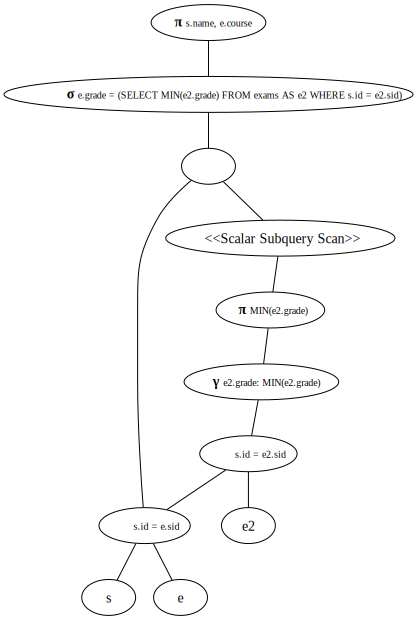

In [5]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)

print(parser.str_relalg(relalg_query_1))
print(relalg_query_1.inspect())
print(relalg_query_2.inspect())

opt_vis.plot_relalg(relalg_query_1)

### Optimierung?

In [6]:
from src.optimizer.optimizer import Optimizer

optimizer = Optimizer()
optimized_nodes = optimizer.optimize_unnesting(relalg_query_1)

print(optimized_nodes[0].node_type)

print(optimized_nodes[1].parent_node)

(⋈ ϴ=(s.id = e.sid), π (MIN(e2.grade)))
[ColumnReference(name='id', table=TableReference(full_name='students', alias='s', virtual=False))]
